# California Housing Price 
reference : exercise in chapter 2 of 'Hands-On Machine Learning with Scikit-learn and Tensorflow' by Aurélien Géron. 

##### Tip> shortcuts for Jupyter Notebook
* Ctrl + Enter : run cell
* Shift + Enter : run cell and select below

## 1. Data Load

Load the data by using *read_csv()* method in __Pandas__ module. Then, let's take a look at the top 10 rows using the *head()* method. 

In [1]:
# Data load
import pandas as pd

housing = pd.read_csv('housing.csv')
housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


Let's see the distribution of the data by using __matplotlib__ module briefly.

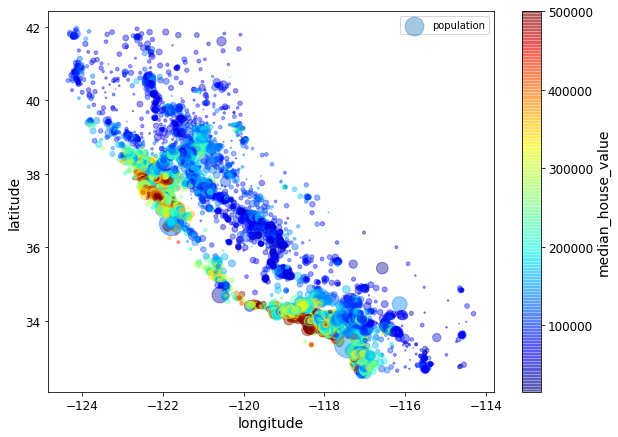

In [2]:
# figures plotting with data
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/50, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

plt.legend()

To better understand the characteristics of each feature, let's apply the *info()* method.

In [3]:
# check a structure of the data
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Let’s look at how much each attribute correlates with the *median house value*:

In [4]:
# correlation between the median_house_value and other features
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

## 2. Prepare the Data

this step consists of 'pre-processing', 'train-test seperation', and 'feature-label seperation'.

### 2-1) Pre-processing 

#### 2-1.1) Data cleaning
Most Machine Learning algorithms cannot work with missing features, so let’s replace the empty values of 'total_bedrooms' with the median value.

In [5]:
# replace the empty values with the median
median =housing["total_bedrooms"].median()
housing["total_bedrooms"] = housing["total_bedrooms"].fillna(median) 
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20640 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


#### 2-1.2) Attributes combinations
*rooms_per_household* is more meaningful than *total_rooms*. Also, *bedrooms_per_room* is more meaningful than *total_bedrooms*.

In [6]:
# Attributes combinations
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
del housing["total_rooms"], housing["total_bedrooms"]

housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude              20640 non-null float64
latitude               20640 non-null float64
housing_median_age     20640 non-null float64
population             20640 non-null float64
households             20640 non-null float64
median_income          20640 non-null float64
median_house_value     20640 non-null float64
ocean_proximity        20640 non-null object
rooms_per_household    20640 non-null float64
bedrooms_per_room      20640 non-null float64
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


#### 2-1.3) Feature Scaling
Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales.

__Scikit-Learn__ provides a transformer called *StandardScaler* for *standardization*.

In [7]:
# feature standardization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# delete columns of text type and target variable
col_list = list(housing) 
col_list.remove('ocean_proximity') # text type
col_list.remove('median_house_value') # target variable needs not to be scaled

# generate a new dataframe that consist of numeric type only
housing_numeric = housing[col_list]
housing_scaled = scaler.fit_transform(housing_numeric)
# Data type conversion from 'Series' to 'DataFrame'
housing_scaled_df = pd.DataFrame(housing_scaled, index=housing_numeric.index, columns=housing_numeric.columns)

# Concatenate 
housing = pd.concat([housing_scaled_df, housing['median_house_value'], housing['ocean_proximity']], axis=1)
housing.head()

,longitude,latitude,housing_median_age,population,households,median_income,rooms_per_household,bedrooms_per_room,median_house_value,ocean_proximity
0,-1.327835,1.052548,0.982143,-0.974429,-0.977033,2.344766,0.628559,-1.029988,452600.0,NEAR BAY
1,-1.322844,1.043185,-0.607019,0.861439,1.669961,2.332238,0.327041,-0.888897,358500.0,NEAR BAY
2,-1.332827,1.038503,1.856182,-0.820777,-0.843637,1.782699,1.155620,-1.291686,352100.0,NEAR BAY
3,-1.337818,1.038503,1.856182,-0.766028,-0.733781,0.932968,0.156966,-0.449613,341300.0,NEAR BAY
4,-1.337818,1.038503,1.856182,-0.759847,-0.629157,-0.012881,0.344711,-0.639087,342200.0,NEAR BAY


#### 2-1.4) Handling Text and Categorical Attributes
Most Machine Learning algorithms prefer to work with numbers anyway, so let’s convert the 'ocean_proximity' to numbers.

__Pandas__ provides a *get_dummies* method to convert integer categorical values into one-hot vectors. 

In [8]:
# One-hot encoding
housing = pd.get_dummies(housing)
housing.head(10)

,longitude,latitude,housing_median_age,population,households,median_income,rooms_per_household,bedrooms_per_room,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-1.327835,1.052548,0.982143,-0.974429,-0.977033,2.344766,0.628559,-1.029988,452600.0,0,0,0,1,0
1,-1.322844,1.043185,-0.607019,0.861439,1.669961,2.332238,0.327041,-0.888897,358500.0,0,0,0,1,0
2,-1.332827,1.038503,1.856182,-0.820777,-0.843637,1.782699,1.155620,-1.291686,352100.0,0,0,0,1,0
3,-1.337818,1.038503,1.856182,-0.766028,-0.733781,0.932968,0.156966,-0.449613,341300.0,0,0,0,1,0
4,-1.337818,1.038503,1.856182,-0.759847,-0.629157,-0.012881,0.344711,-0.639087,342200.0,0,0,0,1,0
5,-1.337818,1.038503,1.856182,-0.894071,-0.801787,0.087447,-0.269730,0.275563,269700.0,0,0,0,1,0
6,-1.337818,1.033821,1.856182,-0.292712,0.037823,-0.111366,-0.200918,-0.320242,299200.0,0,0,0,1,0
7,-1.337818,1.033821,1.856182,-0.237079,0.385698,-0.395137,-0.255232,0.115458,241400.0,0,0,0,1,0
8,-1.342809,1.033821,1.061601,-0.193810,0.249687,-0.942359,-0.458703,0.712372,226700.0,0,0,0,1,0
9,-1.337818,1.033821,1.856182,0.110844,0.560944,-0.094470,-0.185283,-0.223507,261100.0,0,0,0,1,0


### 2-2) Training and Test Set Seperation
__Scikit-Learn__ provides *train_test_split* function to split dataset into multiple subsets in various ways. 

In [9]:
# training - test seperation
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

print('# of train_set : %.0f, # of test_set : %.0f' %(train_set.shape[0], test_set.shape[0]))

# of train_set : 16512, # of test_set : 4128


### 2-3) Features and Target Value Seperation of the Training Set
It’s time to prepare the data for your Machine Learning algorithms. 

Let’s separate the features and target value to generate the model H(X).

In [10]:
# feature and label seperation of training set
train_set_features = train_set.drop('median_house_value',axis=1)
train_set_target = train_set["median_house_value"].copy()

## 3. Linear Regression
generate the linear regression model by using *LinearRegression* function from __Scikit-learn__.

For calculating our RMSE, *mean_square_error* function will be used from __scikit-learn__. Also, __numpy__ module will be used to use sqaure-root operation.

 $$RMSE = \sqrt{\sum{(y - \widehat y)^2}\over N}$$
 <br/>
 
$y$ : actual median_house_value, $\widehat y$ : median_house_value predicted. $N$ : total number of data<br/>

In [11]:
def RMSE_calculation(param1, param2):
    mse = mean_squared_error(param1, param2)
    rmse = np.sqrt(mse)

    return rmse

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np # for a sqaure root calcuation

# generate model by using training set
lin_reg = LinearRegression()
lin_reg.fit(train_set_features, train_set_target) 

# Feature and target value Seperation of the test set
test_set_features = test_set.drop('median_house_value',axis=1)
test_set_target = test_set["median_house_value"].copy()

# target value predicted from our model
train_final_predictions = lin_reg.predict(train_set_features)
test_final_predictions = lin_reg.predict(test_set_features)

# RMSE
train_final_rmse = RMSE_calculation(train_set_target, train_final_predictions)
test_final_rmse = RMSE_calculation(test_set_target, test_final_predictions)

print('train_RMSE : %.2f , test_RMSE : %.2f' %(train_final_rmse, test_final_rmse))

train_RMSE : 67631.16 , test_RMSE : 72337.41


## 4. Linear Regression with Gradient Descent

To compute matrix calculations easily, convert data types from dataframe to numpy array. 

In [13]:
train_set_features_array = train_set_features.values
train_set_target_array =np.expand_dims(train_set_target,axis=1)

test_set_features_array = test_set_features.values
test_set_target_array = np.expand_dims(test_set_target,axis=1)

train_y = train_set_target.values.reshape(-1,1)
test_y = test_set_target.values.reshape(-1,1)

Generate the augmented matrix $X_{b}$ by adding bias column which consists of all 1s.

In [14]:
train_bias_column = np.ones([train_set_features_array.shape[0],1])
train_X_b = np.concatenate((train_set_features_array, train_bias_column),axis=1)

test_bias_column = np.ones([test_set_features_array.shape[0],1])
test_X_b = np.concatenate((test_set_features_array, test_bias_column),axis=1)

### 4-1) Batch Gradient Descent

The gradient descent mothod is as follows.

$$ \theta \leftarrow \theta - \eta\nabla_{\theta} J(\theta) \quad ,\,where \; \eta = learning\, rate$$ 


Recall that 

$$ \nabla_{\theta} J(\theta) = X^{T}X\theta - X^{T}y $$
$$ = X^{T}(X\theta-y)$$

It is batch gradient descent that $X$ contains all training instances.

At first, initialize $\theta$ and store the training RMSE and validation RMSE for this initialized $\theta$.

In [15]:
# initialize theta 
feature_num = train_X_b.shape[1]
theta = np.random.randn(feature_num,1)

GD_train_rmse = []
GD_val_rmse = []

initialized_theta_train_RMSE = RMSE_calculation(np.dot(train_X_b,theta), train_y)
initialized_theta_val_RMSE = RMSE_calculation(np.dot(test_X_b,theta), test_y)

GD_train_rmse.append(initialized_theta_train_RMSE)
GD_val_rmse.append(initialized_theta_val_RMSE)

print('RMSE of the initialized theta - train_RMSE : %.2f, val_RMSE : %.2f' %(initialized_theta_train_RMSE, initialized_theta_val_RMSE))

RMSE of the initialized theta - train_RMSE : 237271.46, val_RMSE : 235233.51


Execute your batch gradient descent.

In [16]:
train_num = train_X_b.shape[0]

batch_size = train_num
n_epoch = 10000
eta = 0.001 # learning rate

for epoch in range(n_epoch):
    gradient = 2 / batch_size * np.dot(train_X_b.T , np.dot(train_X_b, theta) - train_y)
    theta = theta - eta * gradient
    
    # train error
    GD_train_predictions = np.dot(train_X_b, theta)
    GD_train_final_rmse = RMSE_calculation(train_y, GD_train_predictions)
    GD_train_rmse.append(GD_train_final_rmse)
    
    # val error
    GD_val_predictions = np.dot(test_X_b, theta)
    GD_val_final_rmse = RMSE_calculation(test_y, GD_val_predictions)
    GD_val_rmse.append(GD_val_final_rmse)
    
    if epoch%100 == 0:
        print('%d번째 train_RMSE : %.2f, val_RMSE : %.2f' %(epoch, GD_train_final_rmse, GD_val_final_rmse))

0번째 train_RMSE : 236714.92, val_RMSE : 234686.73
100번째 train_RMSE : 188979.95, val_RMSE : 187842.97
200번째 train_RMSE : 154323.30, val_RMSE : 153898.16
300번째 train_RMSE : 129548.90, val_RMSE : 129652.64
400번째 train_RMSE : 112153.87, val_RMSE : 112617.61
500번째 train_RMSE : 100148.36, val_RMSE : 100833.23
600번째 train_RMSE : 91964.22, val_RMSE : 92771.37
700번째 train_RMSE : 86406.83, val_RMSE : 87278.17
800번째 train_RMSE : 82608.32, val_RMSE : 83519.37
900번째 train_RMSE : 79967.29, val_RMSE : 80916.68
1000번째 train_RMSE : 78082.63, val_RMSE : 79082.41
1100번째 train_RMSE : 76693.75, val_RMSE : 77762.12
1200번째 train_RMSE : 75633.88, val_RMSE : 76790.56
1300번째 train_RMSE : 74796.83, val_RMSE : 76060.41
1400번째 train_RMSE : 74114.79, val_RMSE : 75501.38
1500번째 train_RMSE : 73544.06, val_RMSE : 75066.75
1600번째 train_RMSE : 73056.00, val_RMSE : 74724.83
1700번째 train_RMSE : 72631.45, val_RMSE : 74453.55
1800번째 train_RMSE : 72257.26, val_RMSE : 74237.17
1900번째 train_RMSE : 71924.10, val_RMSE : 74064.12


Check for changes of RMSE with epoch.

Text(0, 0.5, 'RMSE')

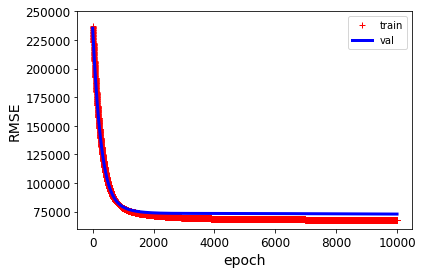

In [17]:
plt.plot(GD_train_rmse, "r+", linewidth=2, label="train")
plt.plot(GD_val_rmse, "b-", linewidth=3, label="val")

plt.ylim([60000, 250000])
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('RMSE')

### 4-2) Mini-Batch Gradient Descent

It is mini-batch gradient descent that  𝑋  contains only a small set of randomly selected training instances.<br/>
It is important to shuffle the order of train instances after each epochs.

Initialize  𝜃  and store the training RMSE and validation RMSE for this initialized  𝜃 .

In [18]:
theta = np.random.randn(feature_num,1)
theta_bkp = theta # back-up the theta values

GD_train_rmse = []
GD_val_rmse = []

GD_batch_train_rmse = []
GD_batch_val_rmse = []

initialized_theta_train_RMSE = RMSE_calculation(np.dot(train_X_b,theta), train_y)
initialized_theta_val_RMSE = RMSE_calculation(np.dot(test_X_b,theta), test_y)

GD_train_rmse.append(initialized_theta_train_RMSE)
GD_val_rmse.append(initialized_theta_val_RMSE)
GD_batch_train_rmse.append(initialized_theta_train_RMSE)
GD_batch_val_rmse.append(initialized_theta_val_RMSE)

print('RMSE of the initialized theta - train_RMSE : %.2f, val_RMSE : %.2f' %(initialized_theta_train_RMSE, initialized_theta_val_RMSE))

RMSE of the initialized theta - train_RMSE : 237270.62, val_RMSE : 235232.66


Execute your mini-batch gradient descent.

In [19]:
batch_size = 128
n_epoch = 100
eta = 0.001 # learning rate

for epoch in range(n_epoch):
    
    # shuffle
    shuffle_indices = np.random.permutation(train_num)
    feature_shuffled = train_X_b[shuffle_indices,:]
    target_shuffled = train_y[shuffle_indices,:]
    
    for i in range(0, train_num, batch_size):
        batch_x = feature_shuffled[i:i+batch_size,:]
        batch_y = target_shuffled[i:i+batch_size,:]

        gradient = 2/batch_size * np.dot(batch_x.T , np.dot(batch_x, theta) - batch_y)
        theta = theta - eta * gradient
        
        # train error after batch update 
        train_batch_predictions = np.dot(train_X_b, theta)
        train_batch_rmse = RMSE_calculation(train_y, train_batch_predictions)
        GD_batch_train_rmse.append(train_batch_rmse)
        
        # test error after batch update
        val_batch_predictions = np.dot(test_X_b, theta)
        val_batch_rmse = RMSE_calculation(test_y, val_batch_predictions)
        GD_batch_val_rmse.append(val_batch_rmse)
        
    # train error after epoch 
    GD_train_predictions = np.dot(train_X_b, theta)
    GD_train_final_rmse = RMSE_calculation(train_y, GD_train_predictions)
    GD_train_rmse.append(GD_train_final_rmse)
    
    # val error after epoch 
    GD_val_predictions = np.dot(test_X_b, theta)
    GD_val_final_rmse = RMSE_calculation(test_y, GD_val_predictions)
    GD_val_rmse.append(GD_val_final_rmse)
    
    if epoch%10 == 0:
        print('%d번째 train_RMSE : %.2f, val_RMSE : %.2f' %(epoch, GD_train_final_rmse, GD_val_final_rmse))

0번째 train_RMSE : 178115.56, val_RMSE : 177198.20
10번째 train_RMSE : 74002.77, val_RMSE : 75416.41
20번째 train_RMSE : 70157.95, val_RMSE : 73504.35
30번째 train_RMSE : 68934.44, val_RMSE : 73443.96
40번째 train_RMSE : 68424.70, val_RMSE : 73383.24
50번째 train_RMSE : 68177.75, val_RMSE : 73237.36
60번째 train_RMSE : 68043.36, val_RMSE : 73083.93
70번째 train_RMSE : 67962.44, val_RMSE : 72947.81
80번째 train_RMSE : 67909.15, val_RMSE : 72833.05
90번째 train_RMSE : 67871.78, val_RMSE : 72741.51


Check for changes of RMSE with epoch.

Text(0, 0.5, 'RMSE')

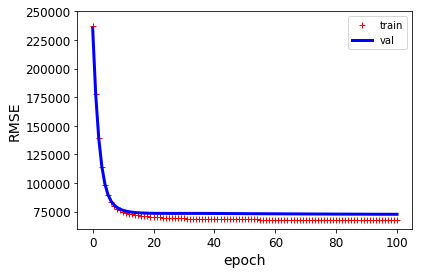

In [20]:
plt.plot(GD_train_rmse, "r+", linewidth=2, label="train")
plt.plot(GD_val_rmse, "b-", linewidth=3, label="val")

plt.ylim([60000, 250000])
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('RMSE')

Check for changes of RMSE with batch update.

Text(0, 0.5, 'RMSE')

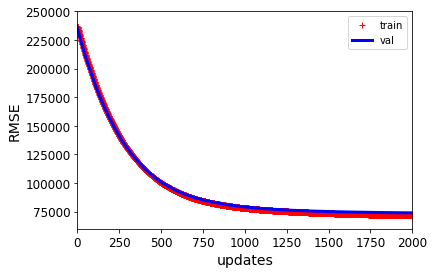

In [21]:
plt.plot(GD_batch_train_rmse, "r+", linewidth=2, label="train")
plt.plot(GD_batch_val_rmse, "b-", linewidth=3, label="val")

plt.ylim([60000, 250000])
plt.xlim([0,2000])
plt.legend(loc='upper right')
plt.xlabel('updates')
plt.ylabel('RMSE')

### 4-3) Stochastic Gradient Descent

It is stochastic gradient descent that $𝑋$ contains only one training instance selected randomly.

Initialize 𝜃 and store the training RMSE and validation RMSE for this initialized 𝜃 

In [22]:
theta = np.random.randn(feature_num,1)
theta_bkp = theta # back-up the theta values

GD_train_rmse = []
GD_val_rmse = []

GD_batch_train_rmse = []
GD_batch_val_rmse = []

initialized_theta_train_RMSE = RMSE_calculation(np.dot(train_X_b,theta), train_y)
initialized_theta_val_RMSE = RMSE_calculation(np.dot(test_X_b,theta), test_y)

GD_train_rmse.append(initialized_theta_train_RMSE)
GD_val_rmse.append(initialized_theta_val_RMSE)
GD_batch_train_rmse.append(initialized_theta_train_RMSE)
GD_batch_val_rmse.append(initialized_theta_val_RMSE)

print('RMSE of the initialized theta - train_RMSE : %.2f, val_RMSE : %.2f' %(initialized_theta_train_RMSE, initialized_theta_val_RMSE))

RMSE of the initialized theta - train_RMSE : 237272.06, val_RMSE : 235234.08


Execute your stochastic gradient descent algorithm.<br/>

In [23]:
######################## Q1. ##################################
#  TO DO : Fill in the blank with your stochastic gradient descent code.
# set the hyper-parameters as follows.
# parameters setting : batch size = 1 , epoch = 50 , learning rate = 0.001

batch_size = 1
n_epoch = 50
eta = 0.001 # learning rate

for epoch in range(n_epoch):
    
    # shuffle
    shuffle_indices = np.random.permutation(train_num)
    feature_shuffled = train_X_b[shuffle_indices,:]
    target_shuffled = train_y[shuffle_indices,:]
    
    for i in range(0, train_num, batch_size):
        batch_x = feature_shuffled[i:i+batch_size,:]
        batch_y = target_shuffled[i:i+batch_size,:]

        gradient = 2/batch_size * np.dot(batch_x.T , np.dot(batch_x, theta) - batch_y)
        theta = theta - eta * gradient
        
        # train error after batch update 
        train_batch_predictions = np.dot(train_X_b, theta)
        train_batch_rmse = RMSE_calculation(train_y, train_batch_predictions)
        GD_batch_train_rmse.append(train_batch_rmse)
        
        # test error after batch update
        val_batch_predictions = np.dot(test_X_b, theta)
        val_batch_rmse = RMSE_calculation(test_y, val_batch_predictions)
        GD_batch_val_rmse.append(val_batch_rmse)
        
    # train error after epoch 
    GD_train_predictions = np.dot(train_X_b, theta)
    GD_train_final_rmse = RMSE_calculation(train_y, GD_train_predictions)
    GD_train_rmse.append(GD_train_final_rmse)
    
    # val error after epoch 
    GD_val_predictions = np.dot(test_X_b, theta)
    GD_val_final_rmse = RMSE_calculation(test_y, GD_val_predictions)
    GD_val_rmse.append(GD_val_final_rmse)
    
    ######################## Q2. ##################################
    # TO DO : Check the RMSE with each 5 epoches.
    if epoch%5 == 0:
        print('%d번째 train_RMSE : %.2f, val_RMSE : %.2f' %(epoch, GD_train_final_rmse, GD_val_final_rmse))
    ##############################################################
    
    
    
##############################################################

0번째 train_RMSE : 68477.48, val_RMSE : 73333.12
5번째 train_RMSE : 67928.76, val_RMSE : 74203.31
10번째 train_RMSE : 68445.69, val_RMSE : 73247.62
15번째 train_RMSE : 68251.17, val_RMSE : 74976.56
20번째 train_RMSE : 68006.72, val_RMSE : 72583.57
25번째 train_RMSE : 68284.88, val_RMSE : 73069.59
30번째 train_RMSE : 68223.27, val_RMSE : 71472.34
35번째 train_RMSE : 67953.04, val_RMSE : 71633.78
40번째 train_RMSE : 68189.87, val_RMSE : 72350.49
45번째 train_RMSE : 67849.03, val_RMSE : 72355.41


Text(0, 0.5, 'RMSE')

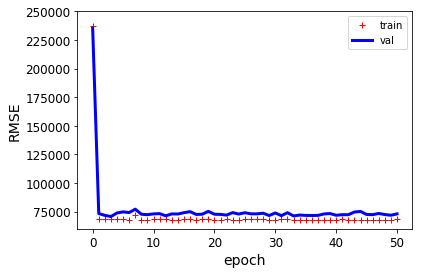

In [24]:
######################## Q3. ##################################
# TO DO : plot the learning curve with each epoch.
plt.plot(GD_train_rmse, "r+", linewidth=2, label="train")
plt.plot(GD_val_rmse, "b-", linewidth=3, label="val")

plt.ylim([60000, 250000])
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('RMSE')
##############################################################

Text(0, 0.5, 'RMSE')

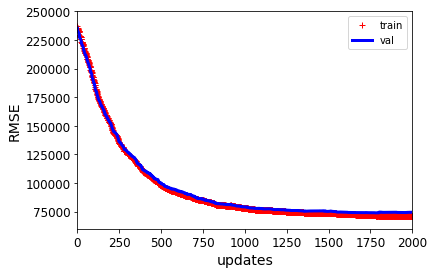

In [25]:
######################## Q4. ##################################
# TO DO : plot the learning curve with each updates.
plt.plot(GD_batch_train_rmse, "r+", linewidth=2, label="train")
plt.plot(GD_batch_val_rmse, "b-", linewidth=3, label="val")

plt.ylim([60000, 250000])
plt.xlim([0,2000])
plt.legend(loc='upper right')
plt.xlabel('updates')
plt.ylabel('RMSE')
##############################################################

### 4-4) Stochastic Gradient Descent using SGDRegressor

Scikit-Learn provide a function for stochastic gradient descent, SGDRegressor().<br/>
SGDRegressor() has 2 methods, 'fit()' and 'partial_fit()'. <br/>
If you use 'fit()' method, you can check the RMSE after total epoches. In the case of 'partial_fit()' method, you can check the RMSE of each epoch.<br/>
To plot the changes of RMSE with each epoch, please use 'partial_fit()' method.<br/>

reference : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html

In [26]:
SGDfunc_train_rmse = []
SGDfunc_val_rmse = []

SGDfunc_initialized_theta_train_RMSE = RMSE_calculation(np.dot(train_X_b,theta_bkp), train_y)
SGDfunc_initialized_theta_val_RMSE = RMSE_calculation(np.dot(test_X_b,theta_bkp), test_y)

SGDfunc_train_rmse.append(SGDfunc_initialized_theta_train_RMSE)
SGDfunc_val_rmse.append(SGDfunc_initialized_theta_val_RMSE)


print('RMSE of the initialized theta - train_RMSE : %.2f, val_RMSE : %.2f' 
      %(SGDfunc_initialized_theta_train_RMSE, SGDfunc_initialized_theta_val_RMSE))

RMSE of the initialized theta - train_RMSE : 237272.06, val_RMSE : 235234.08


Fill in the blanks with your code.

In [30]:
######################## Q1. ##################################
#  TO DO : import SGDRegressor() function.
from sklearn.linear_model import SGDRegressor

##############################################################



######################## Q2. ##################################
# TO DO : set the number of n_epoch to 50
n_epoch = 50
##############################################################



######################## Q3. ##################################
# TO DO : set the parameters of SGDRegressor() as follows.
# parameters setting : penalty='none', learning_rate='constant', eta0=0.001

SGD_model = SGDRegressor(penalty='none', learning_rate='constant', eta0=0.001) 
##############################################################


for epoch in range(n_epoch):   
    ######################## Q4. ##################################
    # TO DO : execute 'partial_fit()' method.
    SGD_model.partial_fit(train_set_features, train_set_target) 
    ##############################################################
    
    # train error
    SGD_train_predictions = SGD_model.predict(train_set_features)
    SGD_train_final_rmse = RMSE_calculation(SGD_train_predictions, train_set_target)
    SGDfunc_train_rmse.append(SGD_train_final_rmse)
    
    # val error
    SGD_val_predictions = SGD_model.predict(test_set_features)
    SGD_val_final_rmse = RMSE_calculation(SGD_val_predictions, test_set_target)
    SGDfunc_val_rmse.append(SGD_val_final_rmse)
    
    if epoch%5 == 0:
           print('%d번째 train_RMSE : %.2f, val_RMSE : %.2f' %(epoch, SGD_train_final_rmse, SGD_val_final_rmse))

    # command to hide the warning box
    import warnings
    warnings.filterwarnings(action = 'ignore')


0번째 train_RMSE : 68728.92, val_RMSE : 73476.92
5번째 train_RMSE : 67861.08, val_RMSE : 73555.34
10번째 train_RMSE : 67837.25, val_RMSE : 71997.87
15번째 train_RMSE : 69477.68, val_RMSE : 74168.63
20번째 train_RMSE : 67791.09, val_RMSE : 72755.61
25번째 train_RMSE : 68066.16, val_RMSE : 72017.70
30번째 train_RMSE : 67855.04, val_RMSE : 73224.67
35번째 train_RMSE : 67808.25, val_RMSE : 72786.78
40번째 train_RMSE : 76195.70, val_RMSE : 80028.27
45번째 train_RMSE : 67901.23, val_RMSE : 72377.19


Text(0, 0.5, 'RMSE')

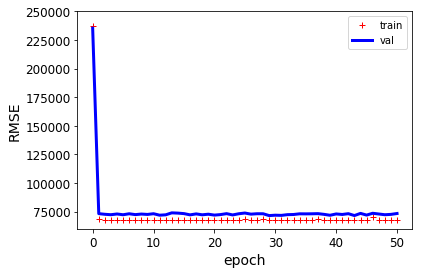

In [28]:
######################## Q5. ##################################
# TO DO : plot the learning curve as epoch changes.
plt.plot(SGDfunc_train_rmse, "r+", linewidth=2, label="train")
plt.ylim([60000, 250000])                         # not shown in the book
plt.plot(SGDfunc_val_rmse, "b-", linewidth=3, label="val")
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('RMSE')
##############################################################